# $\textit{Detección por voz de sexo}$

$\textit{By Bautista Schneeberger, Agustin Gullino y Gonzalo Linares}$

In [1]:
import os

if not os.path.exists("VoxCeleb_gender"):
    !pip install gdown pydub librosa
    !gdown https://drive.google.com/uc?id=1V3lNnSDv71AJYIj71V4_xD0ir0DrXxEV
    !tar -xf VoxCeleb_gender.zip #!tar -xf VoxCeleb_gender.zip
    !del VoxCeleb_gender.zip     #!del

else:
    print("Dataset already downloaded.")

Dataset already downloaded.


$\textit{Implementación del cálculo de los MFCCs}$

In [39]:
import librosa
import scipy.signal as ss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
sns.set_theme()

def extract_mfcc(file_path, n_mfcc=12, win_length=320, hop_length=160):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    if sr != 16000:
        wave = librosa.resample(wave, sr, 16000)
    mfcc = librosa.feature.mfcc(y=wave, sr=16000, n_mfcc=n_mfcc, window=ss.windows.hamming, win_length=win_length, hop_length=hop_length)
    return mfcc

$\textit{Elegimos la cantidad de MFCCs y tamaño de la trama}$

In [40]:
mfcc_coeff_amount = 24
n_components = 10
window_length = int(16000*0.02)

In [41]:
arr = []
if not os.path.exists(f"mfcc_{mfcc_coeff_amount}_{window_length}.pkl"):

    aux = []

    for (dirpath, dirnames, filenames) in os.walk("VoxCeleb_gender"):
        for filename in filenames:
            if filename.endswith(".wav"):
                filepath = dirpath + "/" + filename
                aux.append({"file": filepath, "gender": "females" if "females" in dirpath else "males"})

    df = pd.DataFrame(aux)

    df["mfcc"] = pd.Series(name="mfcc", dtype=object)

    for i in range(len(df)):
        mfcc_coeffs = extract_mfcc(df.loc[i, "file"], n_mfcc=mfcc_coeff_amount, win_length=window_length)
        for i, coeffs in enumerate(mfcc_coeffs):
            if np.linalg.norm(coeffs) < 1:
                mfcc_coeffs.pop(i)
        arr.append(mfcc_coeffs)
    df["mfcc"] = arr
    df.to_pickle(f"mfcc_{mfcc_coeff_amount}_{window_length}.pkl")
else:
    print("File Found")
    df = pd.read_pickle(f"mfcc_{mfcc_coeff_amount}_{window_length}.pkl")


num_males = len(df.loc[df.gender == "males"] )           
num_females = len(df.loc[df.gender == "females"] )              

File Found


In [42]:
print("Number of males: ", num_males)
print("Number of females: ", num_females)

Number of males:  3682
Number of females:  2311


In [43]:
display(df) #Cada fila tiene los datos de un audio, cada columna mfcc contiene n_mfcc x timesteps 

,file,gender,mfcc
0,VoxCeleb_gender/males/2067.wav,males,"[[-478.53528, -459.50067, -454.37323, -453.799..."
1,VoxCeleb_gender/males/3436.wav,males,"[[-364.4941, -336.15237, -331.1945, -331.9108,..."
2,VoxCeleb_gender/males/952.wav,males,"[[-379.75958, -377.99985, -384.4355, -409.9080..."
3,VoxCeleb_gender/males/920.wav,males,"[[-590.7042, -599.7578, -625.10205, -613.7978,..."
4,VoxCeleb_gender/males/3277.wav,males,"[[-163.64647, -193.33449, -166.30594, -163.021..."
...,...,...,...
5988,VoxCeleb_gender/females/396.wav,females,"[[-280.3726, -254.26328, -266.97034, -255.1885..."
5989,VoxCeleb_gender/females/1239.wav,females,"[[-301.9855, -270.2528, -297.23227, -305.43774..."
5990,VoxCeleb_gender/females/136.wav,females,"[[-396.32053, -393.2348, -391.1963, -403.0387,..."
5991,VoxCeleb_gender/females/1563.wav,females,"[[-218.55516, -289.2457, -299.86298, -319.1746..."


$\textit{Separamos entre train y test}$

In [44]:
from sklearn.model_selection import train_test_split

#Equalize number of gender in dataset
# gender_counts = df['gender'].value_counts()
# difference = abs(gender_counts['males'] - gender_counts['females'])
# if gender_counts['males'] > gender_counts['females']:
#     df_balanced = df.drop(df[df['gender'] == 'males'].sample(n=difference, random_state=42).index)
# else:
#     df_balanced = df.drop(df[df['gender'] == 'females'].sample(n=difference, random_state=42).index)

#Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(df.drop(['gender'], axis=1), df['gender'], test_size=0.2)
X_file, X_test_file = X_train["file"], X_test["file"]
X_train.drop(["file"], inplace=True, axis=1)
X_test.drop(["file"], inplace=True, axis=1)


# $\textit{EDA}$

$\textit{Observamos la media de los MFCCs de cada sexo}$

In [45]:
# Get the mean mfcc coefficients for each class
mean_mfcc_males = 0
mean_mfcc_females = 0

for i, person in df.iterrows():
    for j in range(len(person["mfcc"])//mfcc_coeff_amount):
        if person["gender"] == "males":
            mean_mfcc_males += np.mean(np.array(person["mfcc"]), axis=1)/num_males
        else:
            mean_mfcc_females += np.mean(person["mfcc"], axis=1)/num_females

display(mean_mfcc_males)
display(mean_mfcc_females)

array([-343.47592  ,  114.5287   ,    6.7193666,   24.8168   ,
         -2.9294763,   -3.0019794,  -10.199322 ,   -6.5843744,
         -6.681044 ,   -2.037037 ,   -3.63324  ,   -1.2979463,
         -5.9663887,    1.0028199,   -4.876493 ,   -3.8429627,
         -3.3035378,   -2.4817235,   -5.4875865,   -1.2745112,
         -4.0380993,   -2.5271084,   -2.8321216,   -1.6360161],
      dtype=float32)

array([-3.4026294e+02,  1.0303488e+02, -1.7889943e+00,  1.7891953e+01,
       -1.1314263e+01, -6.5218291e+00, -1.1096679e+01, -3.6596124e+00,
       -5.2710891e+00, -3.3059134e+00, -4.4010148e+00, -5.8313870e+00,
       -2.3112788e+00, -4.0010505e+00, -7.4459004e+00, -1.4462051e+00,
       -6.0028410e+00, -2.9514472e+00, -3.8211286e+00, -2.7313452e+00,
       -3.7229977e+00, -8.2190895e-01, -3.0793715e+00, -8.7776802e-02],
      dtype=float32)

# $\textit{GMM Model}$

In [46]:
X_male = np.concatenate(X_train.mfcc[y_train=="males"].to_numpy(), axis=1).T
X_female = np.concatenate(X_train.mfcc[y_train=="females"].to_numpy(), axis=1).T
X_test_male = np.concatenate(X_test.mfcc[y_test=="males"].to_numpy(), axis=1).T
X_test_female = np.concatenate(X_test.mfcc[y_test=="females"].to_numpy(), axis=1).T

In [47]:
X_test[y_test=="females"]

,mfcc
3963,"[[-530.48474, -507.7642, -515.70404, -516.8456..."
5847,"[[-271.61725, -326.32086, -389.34912, -401.225..."
5771,"[[-369.6868, -351.97678, -346.01227, -353.9415..."
4030,"[[-588.25275, -563.6342, -558.8579, -569.8467,..."
5437,"[[-394.92505, -378.47043, -348.83762, -322.028..."
...,...
4571,"[[-270.29736, -285.67096, -261.95413, -238.298..."
4148,"[[-281.78058, -323.96292, -326.417, -329.52835..."
3682,"[[-695.8884, -682.8564, -676.40155, -637.6625,..."
4207,"[[-703.78723, -687.34314, -671.3913, -675.2498..."


$\textit{Fit Models}$

In [48]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
import pickle


if not os.path.exists(f"gmm_male_mfcc_{mfcc_coeff_amount}_{window_length}_{n_components}.pkl"):
    
    gmm_male = GaussianMixture(n_components=n_components, covariance_type='full', max_iter=1000)
    gmm_female = GaussianMixture(n_components=n_components, covariance_type='full', max_iter=1000)

    gmm_male.fit(X_male)
    gmm_female.fit(X_female)

    with open(f"gmm_male_mfcc_{mfcc_coeff_amount}_{window_length}_{n_components}.pkl",'wb') as f:
        pickle.dump(gmm_male,f)

    with open(f"gmm_female_mfcc_{mfcc_coeff_amount}_{window_length}_{n_components}.pkl",'wb') as f:
        pickle.dump(gmm_female,f)

else:
    print("File Found")

    with open(f"gmm_male_mfcc_{mfcc_coeff_amount}_{window_length}_{n_components}.pkl",'rb') as f:
        gmm_male = pickle.load(f)

    with open(f"gmm_female_mfcc_{mfcc_coeff_amount}_{window_length}_{n_components}.pkl",'rb') as f:
        gmm_female = pickle.load(f)

In [ ]:
def predict_male(features):
    score = gmm_male.score_samples(features).mean() - gmm_female.score_samples(features).mean()
    return score

$\textit{Observamos la distribucion de los scores para cada trama de cada modelo}$

In [ ]:
scores_fgmm = pd.Series(index=y_test.index)
scores_mgmm = pd.Series(index=y_test.index)

for index, row in X_test.iterrows():
    mfcc = row['mfcc']
    scores_fgmm[index] = predict_male(mfcc.T).mean()
    scores_mgmm[index] = predict_male(mfcc.T).mean()

mean_scoresf = scores_mgmm[y_test == "females"][:1000]
mean_scoresm = scores_mgmm[y_test == "males"][:1000]
df_female_mean = pd.DataFrame({'score': mean_scoresf, 'gender': 'females'})
df_male_mean = pd.DataFrame({'score': mean_scoresm, 'gender': 'males'})
df_scores_mean = pd.concat([df_female_mean, df_male_mean])

display(scores_fgmm[y_test == "males"].mean())
display(scores_fgmm[y_test == "females"].mean())

/tmp/ipykernel_7581/2736226549.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scores_fgmm = pd.Series(index=y_test.index)
/tmp/ipykernel_7581/2736226549.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scores_mgmm = pd.Series(index=y_test.index)


0.9514625080049518

-0.882378835686043

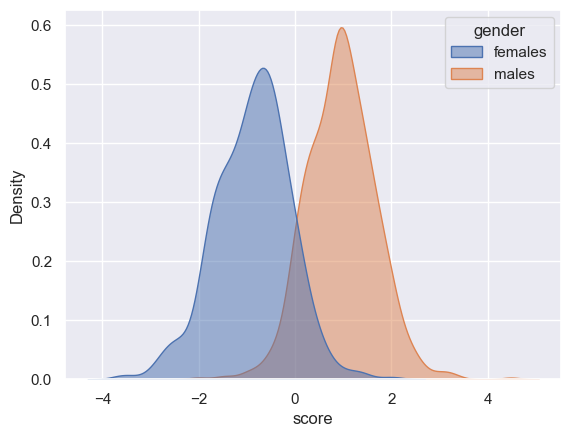

In [ ]:
sns.kdeplot(data=df_scores_mean, x='score', hue='gender', alpha=0.5, fill=True, common_norm=False);

$\textit{Probamos el modelo sobre el test}$

In [ ]:
predictions = []
for index in y_test.index:
    if scores_mgmm[index] > scores_fgmm[index]:
        predictions.append('males')
    else:
        predictions.append('females')

# Convert predictions to a pandas Series
predictions = pd.Series(predictions, index=y_test.index)

# Calculate the accuracy
accuracy = (predictions == y_test).mean()

# Print the accuracy
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 90.91%


$\textit{Probamos el modelo en tiempo real}$

In [ ]:
import pyaudio
from IPython.display import update_display

Chunk = 1024 * 8
format = pyaudio.paFloat32
channels = 1
rate = 16000

In [ ]:
p = pyaudio.PyAudio()

stream = p.open(
    format=format,
    channels=channels,
    rate=rate,
    input=True,
    output=True,
    frames_per_buffer=Chunk,
)
result = "male"
display(result, display_id="res")
while True:
    data = stream.read(Chunk)
    data_int = np.frombuffer(data, dtype=np.float32)
    features = librosa.feature.mfcc(y=data_int, sr=16000, n_mfcc=mfcc_coeff_amount, window=ss.windows.hamming, win_length=window_length, hop_length=window_length//2).T
    score = predict_male(features)
    update_display(f"Is a male speaking?: {score > 0}, with a score of {score}", display_id="res")



ALSA lib pcm.c:2721:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2721:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2721:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib confmisc.c:1377:(snd_func_refer) Unable to find definition 'cards.0.pcm.iec958.0:CARD=0,AES0=4,AES1=130,AES2=0,AES3=2'
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5727:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2721:(snd_pcm_open_noupdate) Unknown PCM iec958
ALSA lib confmisc.c:1377:(snd_func_refer) Unable to find definition 'cards.0.pcm.iec958.0:CARD=0,AES0=4,AES1=130,AES2=0,AES3=2'
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5727:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2721:(snd_pcm_open_noupdate) Unknown PCM spdif
ALSA lib confm

'male?: True, score: 1.4557145630896535'

KeyboardInterrupt: 